In [1]:
import os

import data
import custom_pq
import utils

embed_base = '/data/users/jie/data-slicing/COCO/embeds/'
embed_dir = os.path.join(embed_base, 'train2017_mobilesam_fixed_maskclip')
new_pickle_name = 'coco-2017-train-clip-embeds-fast-2.pkl'
new_pickle_path = os.path.join(embed_base, new_pickle_name)

embed_dict = utils.create_new_pickle(embed_dir, new_pickle_path)
average_embeddings = embed_dict['average_embeddings']


In [2]:
import importlib
importlib.reload(data)
%load_ext autoreload
%autoreload 2


import math

dim = average_embeddings.shape[1]
# k_coarse = int(math.sqrt(average_embeddings.shape[0]))
k_coarse = 1000
m = 64
nbits = 8
nprobes = 3

print(k_coarse)

train_sample_size = int(128 * math.sqrt(average_embeddings.shape[0]))
# data_sample_size = int(32 * math.sqrt(average_embeddings.shape[0]))
# train_sample_size = None
data_sample_size = None

index_pq, index_flat_cpu, \
    packd, img_concept_bitmap, all_images, \
    pqq, kmeans = data.get_indices(dim=dim, \
                                   k_coarse=k_coarse, \
                                   m=m, cluster_bits=nbits, \
                                   embed_dict=embed_dict,
                                   train_sample_size=train_sample_size,
                                   data_sample_size=data_sample_size,
                                   n_probes=nprobes
                                   )

1000
Training on subset 0.04472481628576765
Kmeans trained
521 1024


118287it [01:18, 1509.42it/s]


Building IVFPQ index
Building Flat index
Building IVFOPQ index


In [22]:
import clip_helper


features = clip_helper.get_text_features(
    ['house', 'grass', 'dog']
    # ['black dog', 'white dog']
)



In [12]:
feature_v = embed_dict['average_embeddings'][9999:10001]
features = {'v1': feature_v[0], 'v2': feature_v[1]}

In [27]:
from search_concept import perform_search
from search_expand import flat_multisearch
# importlib.reload(perform_search)
# importlib.reload(flat_multisearch)

nprobes=10
index_flat_cpu.nprobe = nprobes
index_pq.nprobe = nprobes

vec_to_img = embed_dict['vec_to_img']
img_to_vec_list = embed_dict['img_to_vec_list']
p_k = 10

our_search_results, all_img_distances = perform_search(features, p_k, 
    kmeans=kmeans, pqq=pqq, packd=packd, img_concept_bitmap=img_concept_bitmap,
    all_images=all_images, exclusive_matching=False, n_probes=nprobes)
                                                       
search_results, distances_pq = flat_multisearch(index_pq, features, p_k, 
                                vec_to_img,
                                  exclusive_matching=False)
# features2 = get_text_features(["black dog next to white dog"])
search_results_flat, distances_flat = flat_multisearch(index_flat_cpu, features, p_k, 
                                        vec_to_img,
                                       exclusive_matching=False)

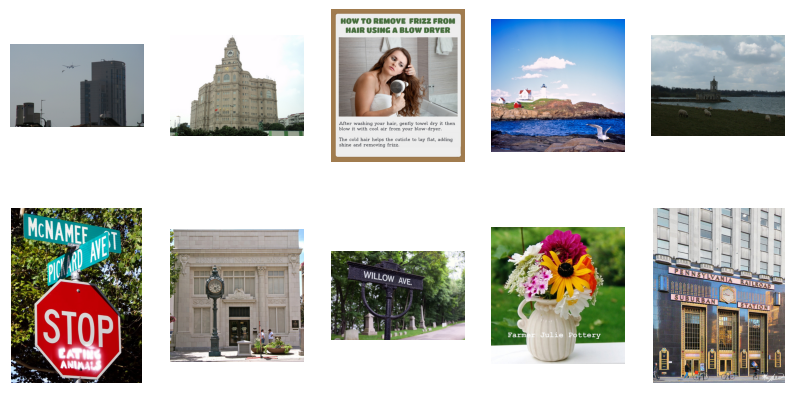

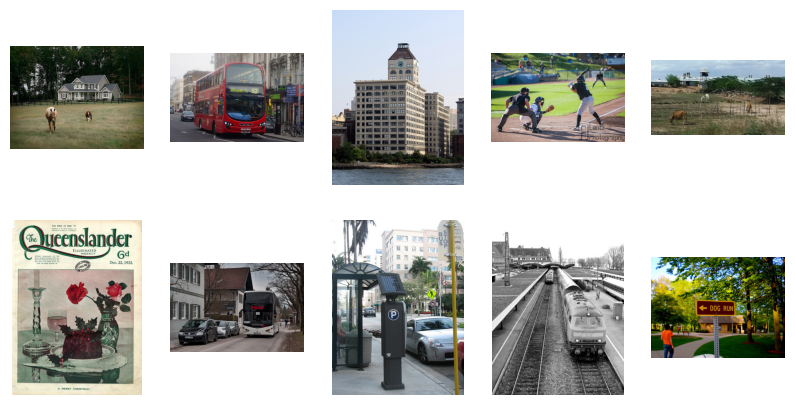

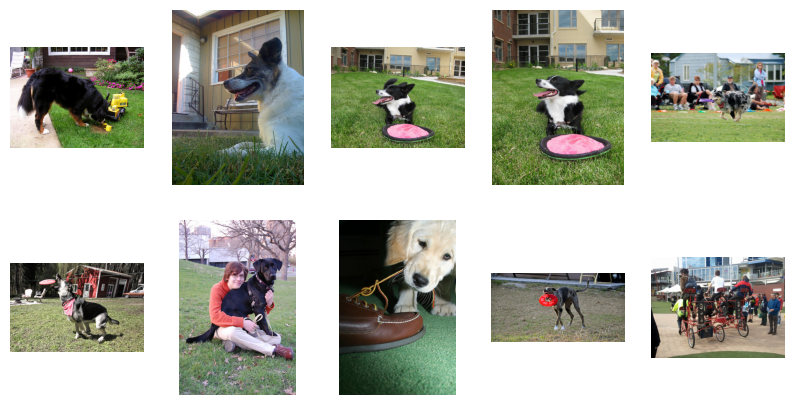

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt

coco_img_dir = '/data/users/jie/data-slicing/COCO/train2017/'

def plot_images(images, n_cols=5):
    n_rows = (len(images) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    for img, ax in zip(images, axes.ravel()):
        img_data = Image.open(os.path.join(coco_img_dir, img))
        ax.imshow(img_data)
        ax.axis('off')

    plt.show()

plot_images(our_search_results, n_cols=5)
plot_images(search_results, n_cols=5)
plot_images(search_results_flat, n_cols=5)